In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.seed_everything(0)

In [3]:
DATA_DIR = Path('data/1116')
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile, window_size, stride):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size
        
        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            self.indexes.append((i, i + window_size))
            i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        sx, tx = self.indexes[idx]
        sy, ty = sx + 18, tx + 18
        x = self.csv.iloc[sx:tx][self.xcols].to_numpy()
        y = self.csv.iloc[sy:ty][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 300, 3

        return x, y

In [5]:
ds48 = CSVSequentialDataset(TEST_FILES[0], window_size=48, stride=120)
ds120 = CSVSequentialDataset(TEST_FILES[0], window_size=120, stride=120)

# 모델 생성

## LSTM

In [6]:
class M2M_LSTM(nn.Module):
    def __init__(self):
        super(M2M_LSTM, self).__init__()

        self.rnn = nn.LSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           batch_first=True,
                           dropout=0.2,
                           bidirectional=True)

        self.out = nn.LSTM(input_size=128, 
                           hidden_size=3, 
                           num_layers=1, 
                           batch_first=True, 
                           dropout=0, 
                           bidirectional=False)
        self.fc = nn.Linear(128, 3)

    def forward(self, x):
        x, (hiddens, cells) = self.rnn(x) # B, S, 128
        #x, (hiddens, cells) = self.out(x) # B, S, 3
        hs = []
        for i in range(x.shape[1]):
            h = self.fc(x[:, i])
            hs.append(h)
        h = torch.stack(hs, 1)

        return h

In [7]:
model_lstm48 = M2M_LSTM().cuda().eval()
model_lstm48.load_state_dict(torch.load('checkpoint/1127-LSTM-FC-win48/best-ckpt.pth')['model'])

<All keys matched successfully>

In [8]:
model_lstm120 = M2M_LSTM().cuda().eval()
model_lstm120.load_state_dict(torch.load('checkpoint/1127-LSTM-win120/best-ckpt.pth')['model'])

<All keys matched successfully>

# LSTMC

In [9]:
class ResBlock1d(nn.Module):
    def __init__(self, inchannels, channels, kernel_size):
        super(ResBlock1d, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(inchannels, channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(channels),
            nn.LeakyReLU(),
            nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(channels)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(inchannels, channels, 1),
            nn.BatchNorm1d(channels)
        )
        self.act = nn.LeakyReLU()

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        identity = self.conv2(identity)
        x += identity
        x = self.act(x)

        return x

In [10]:
class M2M_LSTMC(nn.Module):
    def __init__(self):
        super(M2M_LSTMC, self).__init__()

        self.rnn = nn.LSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           batch_first=True,
                           dropout=0.2,
                           bidirectional=True)
        
        self.conv_out = nn.Sequential(
            ResBlock1d(128, 64, 3),
            nn.Conv1d(64, 3, 1)
        )

    def forward(self, x):
        x, (hiddens, cells) = self.rnn(x) # B, S, 128
        x = x.transpose(1, 2) # B, 128, S
        x = self.conv_out(x) # B, 3, S
        x = x.transpose(1, 2) # B, S, 3

        return x

In [11]:
model_lstmc = M2M_LSTMC().cuda().eval()
model_lstmc.load_state_dict(torch.load('checkpoint/1127-LSTM-Conv-win120/best-ckpt.pth')['model'])

<All keys matched successfully>

## CLSTMC

In [12]:
class CLSTMC(nn.Module):
    def __init__(self):
        super(CLSTMC, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(6, 24, 3, padding=1, groups=2),
            nn.BatchNorm1d(24),
            nn.LeakyReLU(),
            nn.Conv1d(24, 48, 3, padding=1, groups=2),
            nn.BatchNorm1d(48),
            nn.LeakyReLU(),
            nn.Conv1d(48, 64, 3, padding=1),
            nn.BatchNorm1d(64),
        )

        self.rnn = nn.LSTM(input_size=64,
                           hidden_size=64,
                           num_layers=6,
                           batch_first=True,
                           dropout=0,
                           bidirectional=True)

        self.conv_out = nn.Sequential(
            ResBlock1d(128, 64, 3),
            nn.Conv1d(64, 3, 1)
        )

    def forward(self, x):
        x = x.transpose(1, 2)  # B, S, 6 --> B, 6, S
        x = self.conv_in(x)  # B, 6, S
        x = x.transpose(1, 2)  # B, S, 6

        outs, (hiddens, cells) = self.rnn(x)  # B, S, 128
        x = outs.transpose(1, 2)  # B, 128, S
        x = self.conv_out(x) # (B, 3, S)
        x = x.transpose(1, 2) # (B, S, 3)

        return x

In [13]:
model_clstmc = CLSTMC().cuda().eval()
model_clstmc.load_state_dict(torch.load('checkpoint/1124-Scene3-CLSTMC-win120/best-ckpt.pth')['model'])

<All keys matched successfully>

# 결과 비교

In [14]:
torch.set_grad_enabled(False)

In [109]:
j = 0

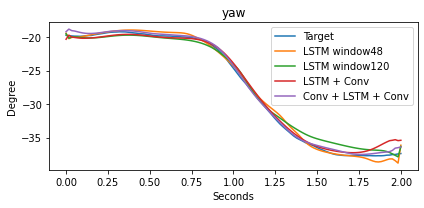

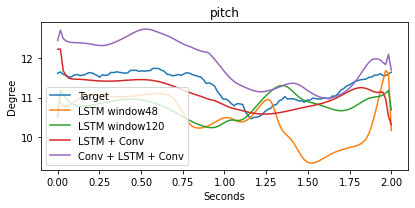

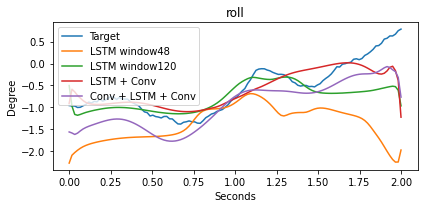

In [69]:
j += 1
x, y = ds120[j]
x = x.unsqueeze(0).cuda()

pred_lstm48 = model_lstm48(x).cpu().squeeze()
pred_lstm120 = model_lstm120(x).cpu().squeeze()
pred_lstmc = model_lstmc(x).cpu().squeeze()
pred_clstmc = model_clstmc(x).cpu().squeeze()

#plt.figure(figsize=(18, 4))
X = np.linspace(0, 2, 120)

for i in range(3):
    plt.figure(figsize=(6, 3))
    #plt.subplot(1, 3, i + 1)
    plt.plot(X, y[:, i])
    plt.plot(X, pred_lstm48[:, i])
    plt.plot(X, pred_lstm120[:, i])
    plt.plot(X, pred_lstmc[:, i])
    plt.plot(X, pred_clstmc[:, i])
    plt.legend(['Target', 'LSTM window48', 'LSTM window120', 'LSTM + Conv', 'Conv + LSTM + Conv'])
    plt.xlabel('Seconds')
    plt.ylabel('Degree')
    
    if i == 0: title = 'yaw'
    if i == 1: title = 'pitch'
    if i == 2: title = 'roll'

    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'img/1127/result-{title}.png')
    plt.show()

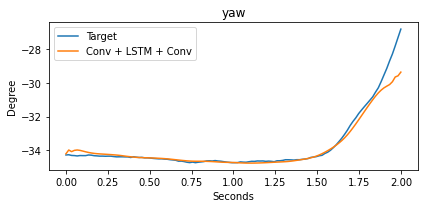

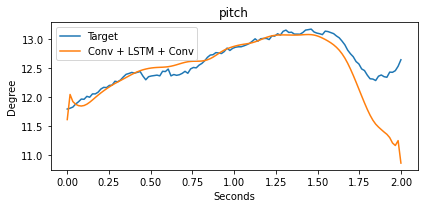

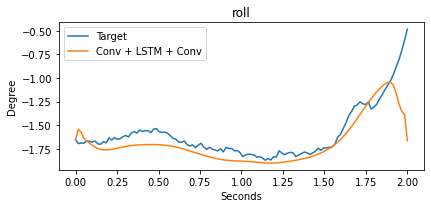

In [122]:
j += 1
x, y = ds120[j]
x = x.unsqueeze(0).cuda()

pred_lstm48 = model_lstm48(x).cpu().squeeze()
pred_lstm120 = model_lstm120(x).cpu().squeeze()
pred_lstmc = model_lstmc(x).cpu().squeeze()
pred_clstmc = model_clstmc(x).cpu().squeeze()

#plt.figure(figsize=(18, 4))
X = np.linspace(0, 2, 120)

for i in range(3):
    plt.figure(figsize=(6, 3))
    #plt.subplot(1, 3, i + 1)
    plt.plot(X, y[:, i])
    plt.plot(X, pred_clstmc[:, i])
    plt.legend(['Target', 'Conv + LSTM + Conv'])
    plt.xlabel('Seconds')
    plt.ylabel('Degree')
    
    if i == 0: title = 'yaw'
    if i == 1: title = 'pitch'
    if i == 2: title = 'roll'

    plt.title(title)
    plt.tight_layout()
    #plt.savefig(f'img/1127/result-{title}.png')
    plt.show()